In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [2]:

import json
import math
import os
import socket
import sys
import time
import datetime
import uuid
from argparse import ArgumentParser
import setproctitle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection
import json

internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import shutil
from utils.args import add_management_args, add_rehearsal_args
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar
from utils.stil_losses import *
from utils.nets import *
from utils.eval import evaluate, validation_and_agreement, distance_models, evaluate_regression

from torch.utils.data import ConcatDataset




/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Looking at the results

errata corridge: x num batches / total number of data points

In [3]:
# load the datasets ... 
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transform = transforms.Compose([
                            transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            normalize,
                        ])
inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', train_transform)
val_dataset = ImageFolder(imagenet_root+'val', inference_transform)

all_data = ConcatDataset([train_dataset, val_dataset])
all_data_loader = DataLoader(all_data, batch_size=256, shuffle=True,num_workers=4, pin_memory=True)

len(all_data_loader)

5200

In [4]:
len(train_dataset)

1281167

## Risk script results

In [5]:
logs_path = './logs/results/imagenet/resnet50/RISK.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
res_df = pd.DataFrame(results)
res_df['risk'] = res_df['risk']*(len(all_data_loader)/len(all_data))
res_df

,risk,e_risk,d_risk,subset_size,subset_fraction,s,k
0,1.997972,1.997927,1.681456,66558,0.05,0,0
1,1.997972,1.998047,1.682086,66558,0.05,1,0
2,1.997972,1.997836,1.682024,66558,0.05,2,0
3,1.997972,1.997927,1.682493,66558,0.05,3,0
4,1.997972,1.997746,1.682598,66558,0.05,4,0
...,...,...,...,...,...,...,...
2366,1.997999,1.998227,1.680211,66558,0.05,66,23
2367,1.997999,1.998137,1.681870,66558,0.05,67,23
2368,1.997999,1.998047,1.681081,66558,0.05,68,23
2369,1.997999,1.998257,1.681416,66558,0.05,69,23


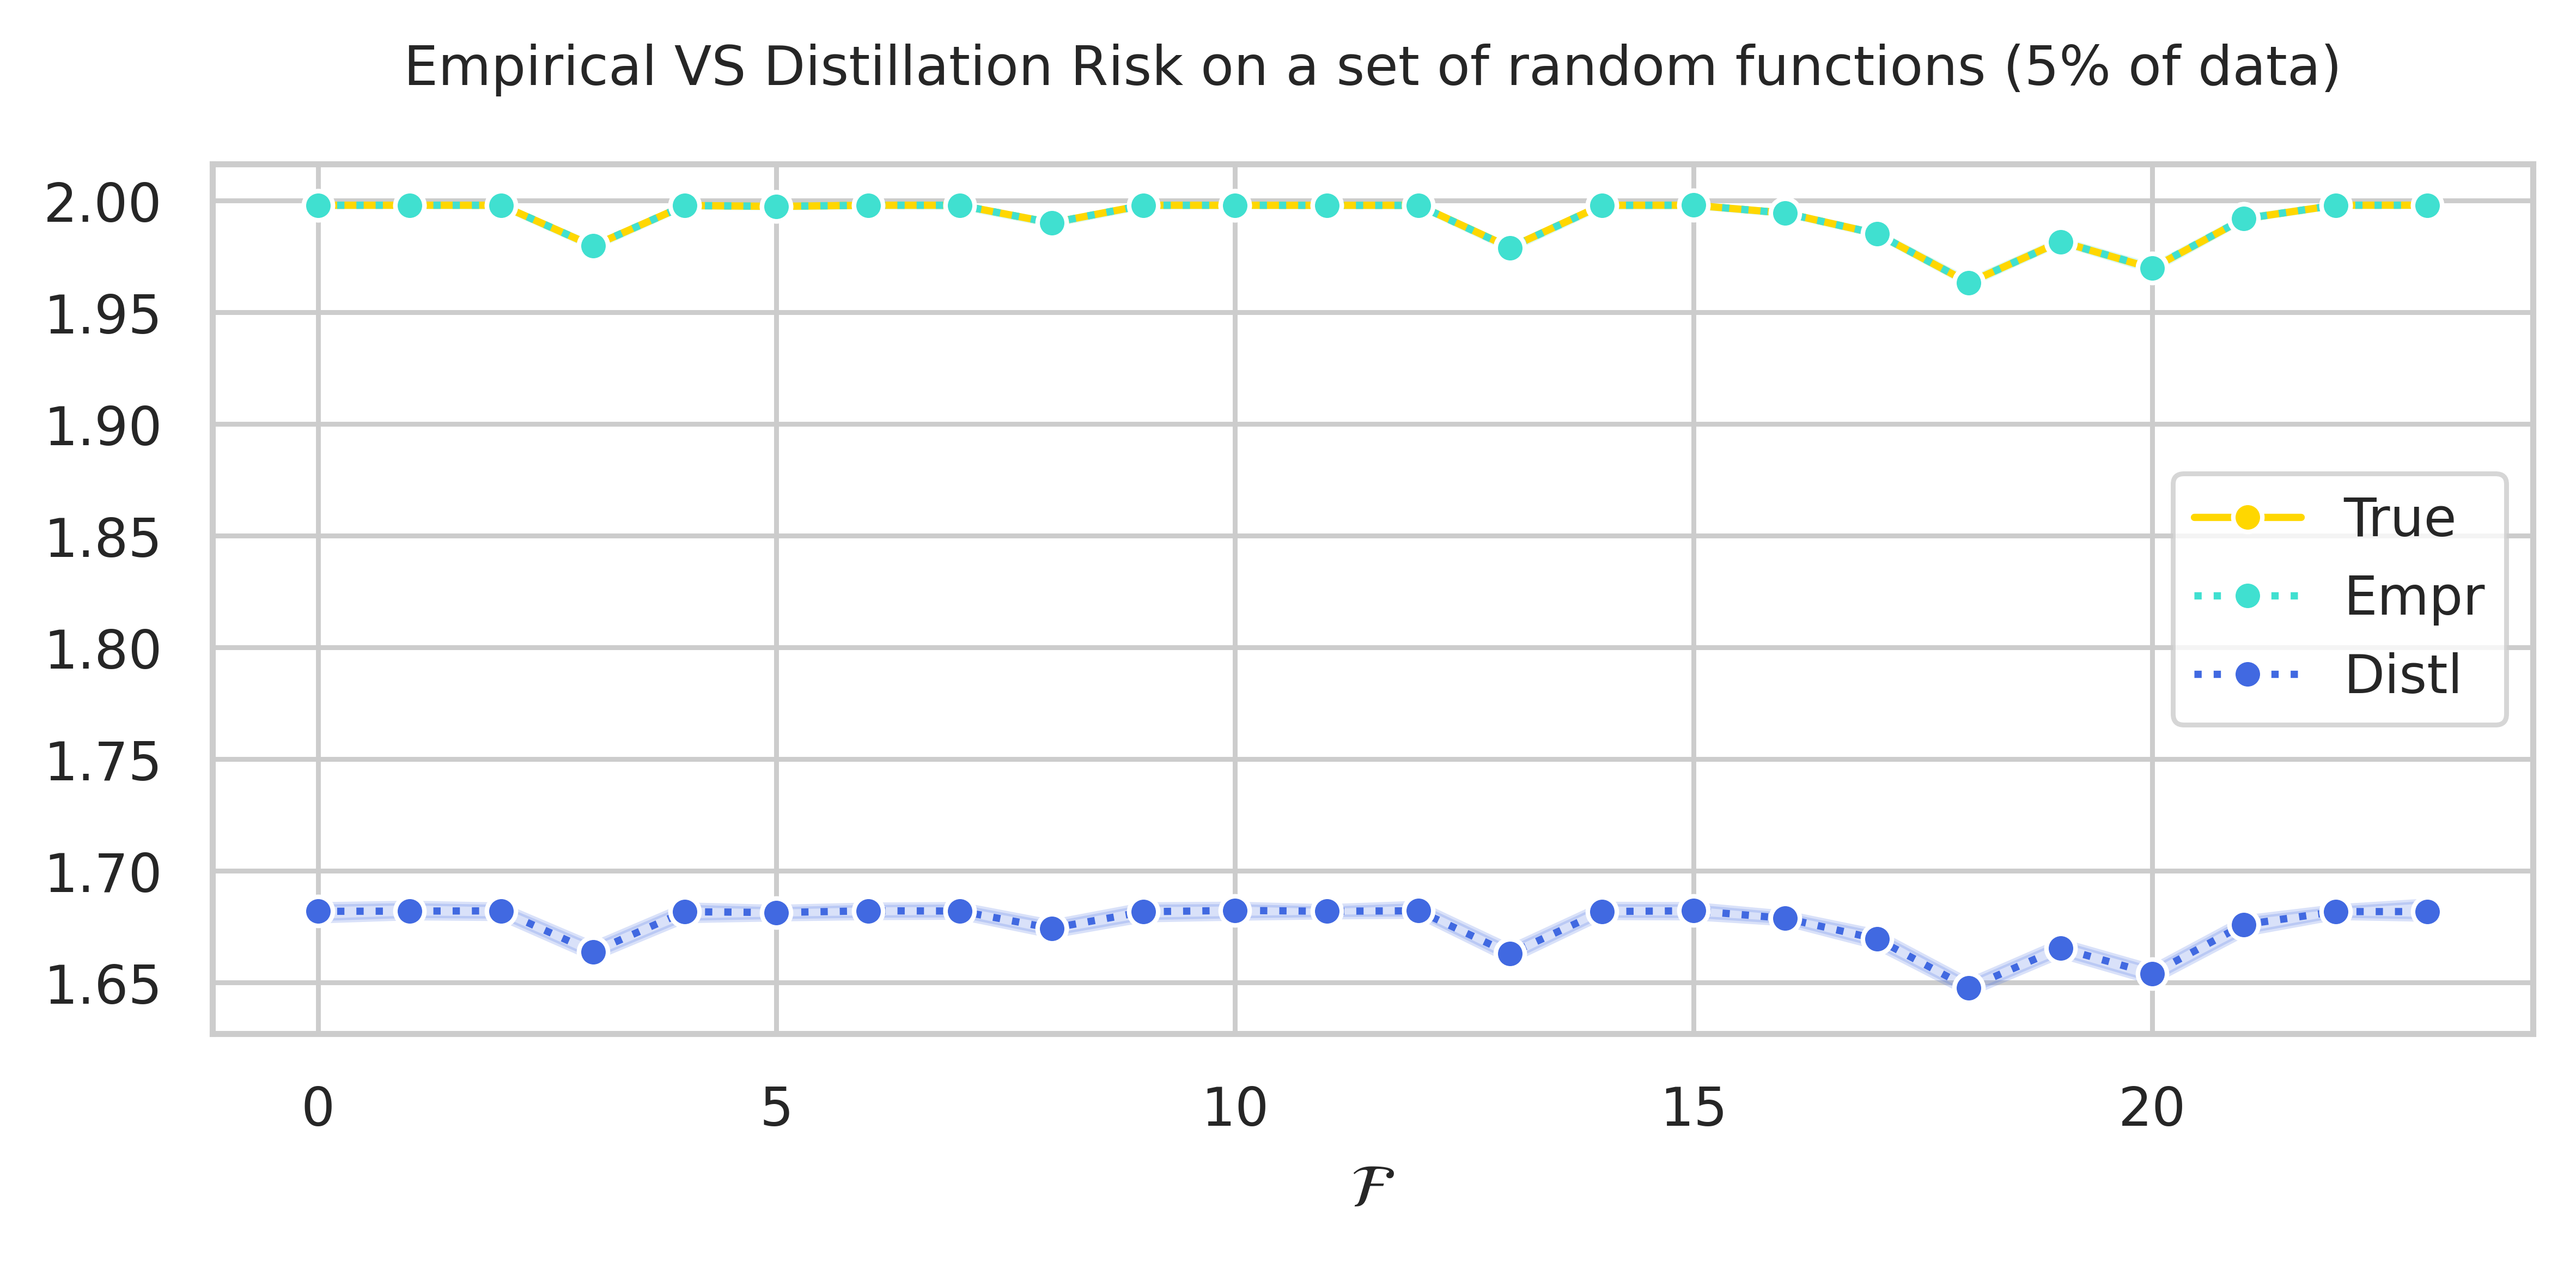

In [6]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    errorbar_fn = lambda x: (x.min(), x.max())
    fig, ax = plt.subplots(figsize=(6,3), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','gold']

    # first plot ---------------------------
    _df = res_df
    sns.lineplot(data=_df, x="k", y="risk", errorbar=errorbar_fn,
                 markers=True, marker='o', color=colors[2], ls='-',ax=ax, label="True")
    sns.lineplot(data=_df, x="k", y="e_risk", errorbar=errorbar_fn,
                 markers=True, marker='o', color=colors[1], ls=':',ax=ax, label="Empr")
    sns.lineplot(data=_df, x="k", y="d_risk", errorbar=errorbar_fn,
                 markers=True, marker='o', color=colors[0], ls=':',ax=ax, label="Distl")

    ax.set_title(r"Empirical VS Distillation Risk on a set of random functions (5% of data)", fontsize=9, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$\mathcal{F}$', fontsize=10, y=+5)
    #ax.set_yscale('log')
    #ax.set_ylim([1.5,2.2])

    #ax.axvline(1.20, ls=':', color='magenta')

    # refinements ---------------------------
    # h, _ = ax.get_legend_handles_labels()
    # ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    # ax[1].legend(h, [r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper right")

    plt.tight_layout()


In [7]:
std_df = res_df.groupby(['k']).agg(np.std)[['e_risk','d_risk']]
std_df = std_df.rename(columns={'e_risk':'e_risk_std','d_risk':'d_risk_std'})
res_df = res_df.merge(std_df, left_on=['k'], right_index=True)
res_df

,risk,e_risk,d_risk,subset_size,subset_fraction,s,k,e_risk_std,d_risk_std
0,1.997972,1.997927,1.681456,66558,0.05,0,0,0.000225,0.001248
1,1.997972,1.998047,1.682086,66558,0.05,1,0,0.000225,0.001248
2,1.997972,1.997836,1.682024,66558,0.05,2,0,0.000225,0.001248
3,1.997972,1.997927,1.682493,66558,0.05,3,0,0.000225,0.001248
4,1.997972,1.997746,1.682598,66558,0.05,4,0,0.000225,0.001248
...,...,...,...,...,...,...,...,...,...
2349,1.997999,1.997596,1.681488,66558,0.05,49,23,0.000243,0.001172
2350,1.997999,1.998468,1.680507,66558,0.05,50,23,0.000243,0.001172
2351,1.997999,1.997836,1.681765,66558,0.05,51,23,0.000243,0.001172
2352,1.997999,1.998167,1.680338,66558,0.05,52,23,0.000243,0.001172


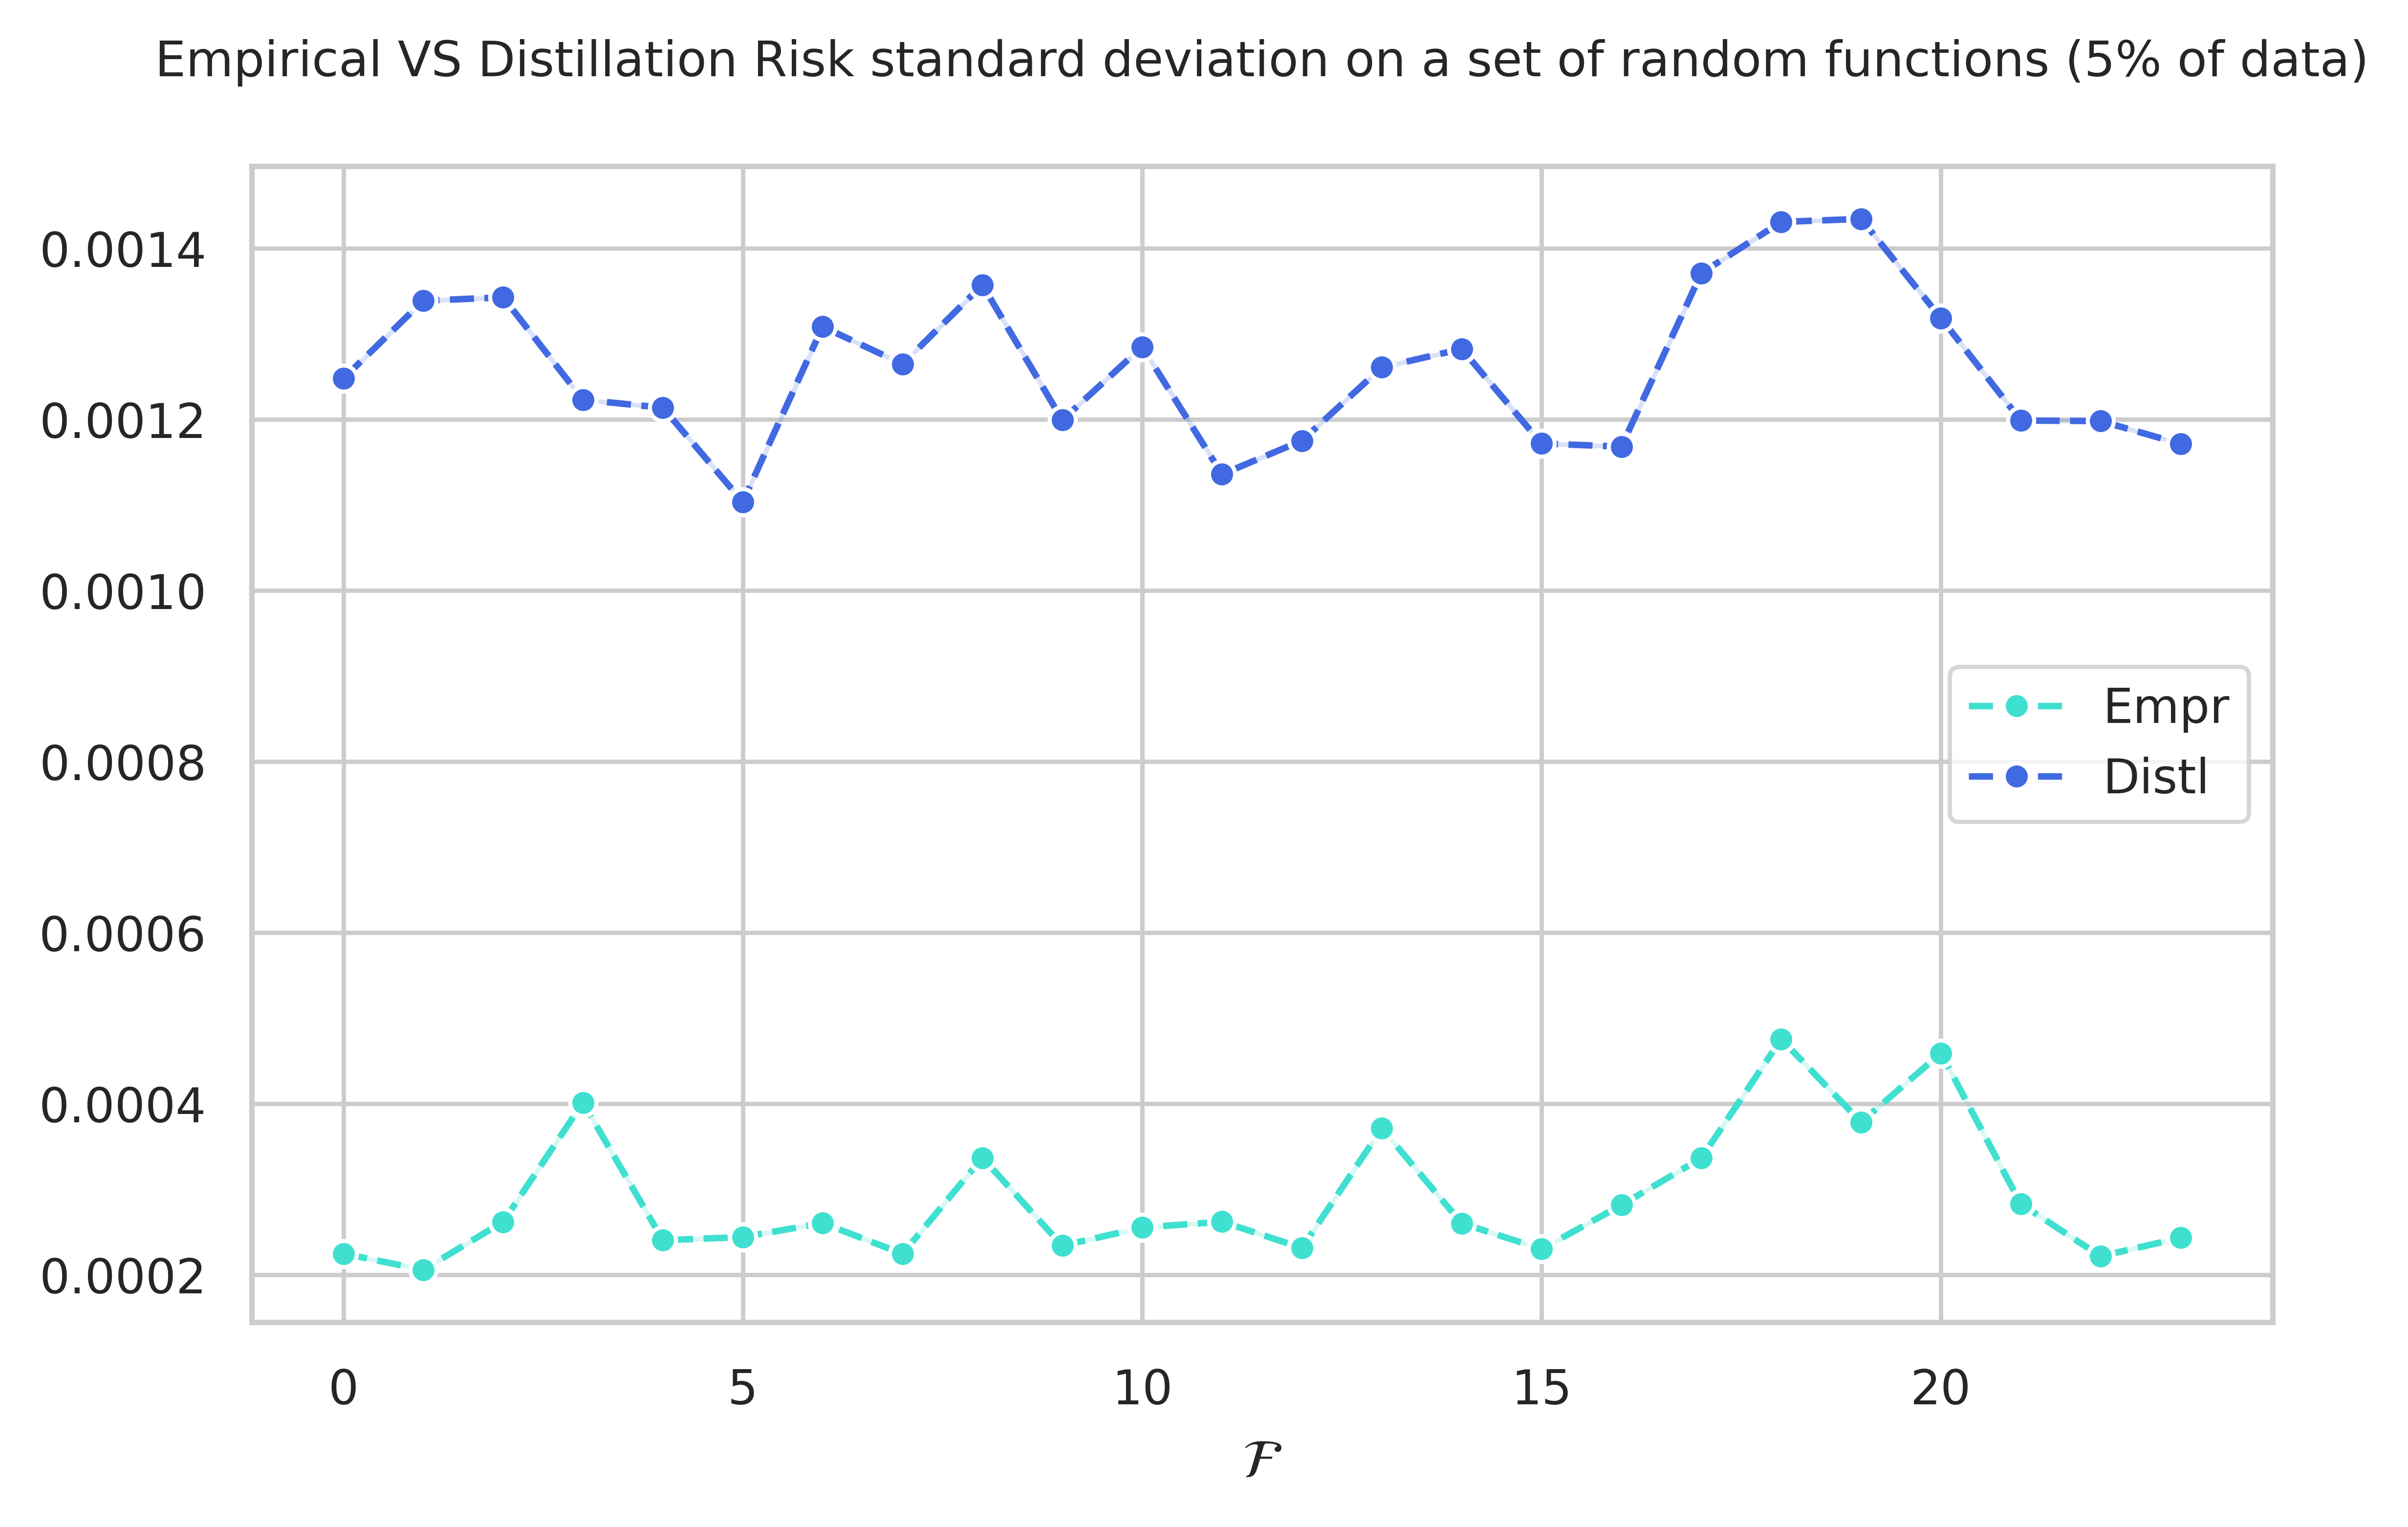

In [8]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(6,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','gold']

    # first plot ---------------------------
    _df = res_df
    
    sns.lineplot(data=_df, x="k", y="e_risk_std", errorbar="sd",
                 markers=True, marker='o', color=colors[1], ls='--',ax=ax, label="Empr")
    sns.lineplot(data=_df, x="k", y="d_risk_std", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="Distl")
    # sns.lineplot(data=_df, x="k", y="risk", errorbar="sd",
    #              markers=True, marker='o', color=colors[2], ls='--',ax=ax, label="True")
    
    ax.set_title(r"Empirical VS Distillation Risk standard deviation on a set of random functions (5% of data)", fontsize=9, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$\mathcal{F}$', fontsize=10, y=+5)
    #ax.set_yscale('log')

    #ax.axvline(1.20, ls=':', color='magenta')

    # refinements ---------------------------
    # h, _ = ax.get_legend_handles_labels()
    # ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    # ax[1].legend(h, [r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper right")

    plt.tight_layout()
